In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "ARF"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn017391,MAASEVSYRGNARGESFSSDYCDPNDGGAGEGNSGGFAHFSGEIPA...,801,1
1,Achn023421,MQFFFFLSLLTIRKKKFNGGGGEKKNINAELWQACAGPLVNLPAAG...,882,1
2,Achn024331,MASRNDVQVQKVETINDVSRCNNQGEKDDLYTQLWHACAGPLVHVP...,1801,1
3,Achn034241,MHTGQPKRHLLTTGWSVFVSAKRLVAGDSVLFIWNEKNQLLLGIRR...,662,1
4,Achn043361,MCGLIDLNTVLDGDETTAASFDSPTPSPPPSTSSGALALGSSSSSS...,753,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
975,0.005747,0.001437,0.001437,0.004310,0.001437,0.005747,0.001437,0.002874,0.002874,0.001437,...,0.000000,0.000000,0.0,0.000000,0.002874,0.002874,0.000000,0.0,0.0,0.001437
4469,0.010753,0.002688,0.008065,0.005376,0.008065,0.013441,0.002688,0.000000,0.010753,0.002688,...,0.000000,0.002688,0.0,0.002688,0.000000,0.000000,0.000000,0.0,0.0,0.005376
5941,0.000000,0.000000,0.000000,0.003175,0.000000,0.003175,0.000000,0.000000,0.006349,0.003175,...,0.003175,0.000000,0.0,0.003175,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1354,0.006422,0.000917,0.002752,0.002752,0.000000,0.003670,0.000917,0.000000,0.000917,0.007339,...,0.001835,0.000917,0.0,0.000917,0.004587,0.000917,0.000917,0.0,0.0,0.000000
5644,0.032258,0.004032,0.012097,0.016129,0.000000,0.004032,0.000000,0.000000,0.000000,0.012097,...,0.000000,0.000000,0.0,0.000000,0.000000,0.004032,0.000000,0.0,0.0,0.000000


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7301, 441)
X_test: (1826, 441)
y_train: (7301,)
y_test: (1826,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 57s 628ms/step - accuracy: 0.4688 - loss: 0.6934

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5871 - loss: 0.6856   

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6935 - loss: 0.6367

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7537 - loss: 0.5592

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7644 - loss: 0.5421 - val_accuracy: 0.9952 - val_loss: 0.0188


Epoch 2/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0699

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9913 - loss: 0.0365 

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0296

82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0277

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0274 - val_accuracy: 0.9945 - val_loss: 0.0167


Epoch 3/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0113

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0151 

53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0133

79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0125

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0127 - val_accuracy: 0.9945 - val_loss: 0.0159


Epoch 4/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0037

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0104 

54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0110

81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0128

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0130 - val_accuracy: 0.9973 - val_loss: 0.0088


Epoch 5/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0025

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0090 

53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0097

80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0097

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0095 - val_accuracy: 0.9966 - val_loss: 0.0089


Epoch 6/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0013

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0084 

54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0080

81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0074

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0071 - val_accuracy: 0.9966 - val_loss: 0.0076


Epoch 7/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0020

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0042 

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0056

81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0055

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0054 - val_accuracy: 0.9952 - val_loss: 0.0097


Epoch 8/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 6.0589e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0015     

54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0026

80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0030

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0030 - val_accuracy: 0.9945 - val_loss: 0.0259


Epoch 9/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0107

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0040 

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0049

82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0047

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0046 - val_accuracy: 0.9966 - val_loss: 0.0112


Epoch 10/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 2.5897e-04

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.6718e-04 

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0011    

82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0015

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0015 - val_accuracy: 0.9959 - val_loss: 0.0152


Epoch 11/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 1.8022e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.8145e-04 

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 5.7989e-04

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 7.7496e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 8.5438e-04 - val_accuracy: 0.9945 - val_loss: 0.0174


Epoch 12/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 5.2466e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.1121e-04 

54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 5.9974e-04

81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 8.7023e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 9.1273e-04 - val_accuracy: 0.9945 - val_loss: 0.0144


Epoch 13/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 1.1690e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 3.3189e-04 

53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0015    

79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0035

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0043 - val_accuracy: 0.9966 - val_loss: 0.0122


Epoch 14/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 3.0280e-04

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 5.3235e-04 

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0011    

80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0015

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 0.9966 - val_loss: 0.0151



[Train Accuracy: 99.93% - Test Accuracy: 99.29%]


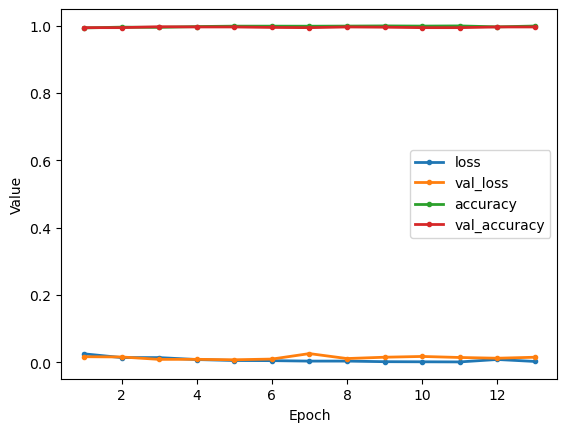

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


 1/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
975,0.001439,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4469,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.002695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5941,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1354,0.002755,0.0,0.0,0.000918,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5644,0.000000,0.0,0.0,0.004049,0.0,0.004049,0.0,0.0,0.0,0.012146,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7301, 8864)
X_test: (1826, 8864)
y_train: (7301,)
y_test: (1826,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,269,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,312,705 (8.82 MB)

 Trainable params: 2,312,705 (8.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 57s 633ms/step - accuracy: 0.4219 - loss: 0.6932

 7/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4948 - loss: 0.6928   

14/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5087 - loss: 0.6922

22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5203 - loss: 0.6908

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5452 - loss: 0.6882

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5776 - loss: 0.6824

45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6076 - loss: 0.6721

52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6310 - loss: 0.6589

60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6549 - loss: 0.6398

68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6757 - loss: 0.6185

76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6942 - loss: 0.5966

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7104 - loss: 0.5752

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7249 - loss: 0.5546

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7266 - loss: 0.5522 - val_accuracy: 0.9973 - val_loss: 0.0082


Epoch 2/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.0023

 8/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0017 

15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0026

23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0036

31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0038

38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0039

46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0039

53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0038

61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0038

69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0038

76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0038

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0037

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0037

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9993 - loss: 0.0037 - val_accuracy: 0.9973 - val_loss: 0.0068


Epoch 3/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 4.9783e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5254e-04 

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1286e-04

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1693e-04

32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.4898e-04

40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7024e-04

48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7869e-04

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7922e-04

63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7541e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7333e-04

79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7680e-04

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7886e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 5.8056e-04 - val_accuracy: 0.9986 - val_loss: 0.0056


Epoch 4/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 3.0715e-04

 8/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9025e-04 

16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8410e-04

24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7915e-04

31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8134e-04

39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7921e-04

47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7778e-04

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7543e-04

63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7284e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7017e-04

79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6731e-04

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6439e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.6228e-04 - val_accuracy: 0.9986 - val_loss: 0.0060


Epoch 5/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 8.9498e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4535e-05 

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.2986e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.8017e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9643e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9439e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.8160e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.6827e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.5829e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.4568e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.3341e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.1864e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 8.0743e-05 - val_accuracy: 0.9986 - val_loss: 0.0061


Epoch 6/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 5.1327e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2713e-05 

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6388e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7838e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9410e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1849e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3389e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3932e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.4090e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3936e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3603e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3161e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 5.3407e-05 - val_accuracy: 0.9979 - val_loss: 0.0068


Epoch 7/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 9.2278e-06

 8/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9498e-05 

16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8392e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9851e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9919e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9720e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9602e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9377e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9135e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8757e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8632e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9409e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 4.0366e-05 - val_accuracy: 0.9979 - val_loss: 0.0069


Epoch 8/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 2.0702e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.8545e-05 

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.0218e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.7918e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.0951e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5406e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1635e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8543e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6395e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4724e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3394e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2319e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 4.1328e-05 - val_accuracy: 0.9986 - val_loss: 0.0066


Epoch 9/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 4.6052e-06

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2337e-05 

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4247e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4536e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4869e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7114e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8153e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8616e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8840e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8904e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8884e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8799e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.8733e-05 - val_accuracy: 0.9986 - val_loss: 0.0067


Epoch 10/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.1610e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0415e-05 

15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0158e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0728e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0961e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0895e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0879e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0942e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1007e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1067e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1107e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1160e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1220e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.1293e-05 - val_accuracy: 0.9986 - val_loss: 0.0068


Epoch 11/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 9.0648e-06

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5340e-05 

16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4721e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4338e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3932e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3928e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4586e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5004e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5161e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5221e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5687e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5962e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.6076e-05 - val_accuracy: 0.9979 - val_loss: 0.0076


Epoch 12/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 1.9794e-06

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.4985e-06 

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.9079e-06

24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0483e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0697e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0878e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1022e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1107e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1164e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1177e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1119e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1057e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.1030e-05 - val_accuracy: 0.9986 - val_loss: 0.0069


Epoch 13/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 1.7652e-06

 8/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.6459e-06 

16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3673e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4445e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4074e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4395e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4464e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4555e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4453e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4287e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4089e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3877e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.3763e-05 - val_accuracy: 0.9986 - val_loss: 0.0073



[Train Accuracy: 100.00% - Test Accuracy: 99.84%]


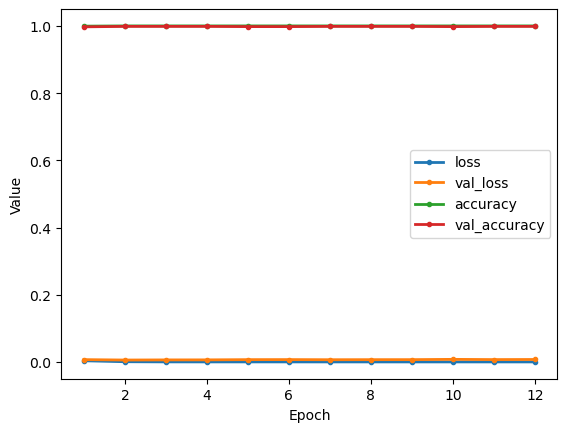

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/58 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

45/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 1/58 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

45/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
975,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4469,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5941,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1354,0.000919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5644,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      39,033,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,074,305 (149.06 MB)

 Trainable params: 39,074,305 (149.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 4:12 3s/step - accuracy: 0.5781 - loss: 0.6931

 2/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.5781 - loss: 0.6930

 3/92 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.5573 - loss: 0.6931

 4/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.5410 - loss: 0.6932

 5/92 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.5322 - loss: 0.6932

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.5303 - loss: 0.6932

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.5320 - loss: 0.6931

 8/92 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.5349 - loss: 0.6931

 9/92 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.5401 - loss: 0.6929

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.5439 - loss: 0.6928

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.5487 - loss: 0.6927

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.5536 - loss: 0.6926

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.5597 - loss: 0.6924

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.5662 - loss: 0.6923

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.5735 - loss: 0.6921

16/92 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.5810 - loss: 0.6919 

17/92 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.5887 - loss: 0.6917

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.5962 - loss: 0.6915

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.6036 - loss: 0.6912

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.6107 - loss: 0.6909

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.6177 - loss: 0.6906

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.6245 - loss: 0.6903

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.6311 - loss: 0.6900

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.6376 - loss: 0.6896

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.6438 - loss: 0.6892

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.6499 - loss: 0.6887

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.6556 - loss: 0.6883

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.6612 - loss: 0.6878

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.6666 - loss: 0.6872

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.6717 - loss: 0.6866

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.6768 - loss: 0.6860

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.6816 - loss: 0.6853

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.6864 - loss: 0.6846

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.6909 - loss: 0.6838

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.6954 - loss: 0.6830

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.6997 - loss: 0.6821

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.7038 - loss: 0.6812

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.7079 - loss: 0.6802

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.7118 - loss: 0.6791

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.7155 - loss: 0.6780

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.7192 - loss: 0.6769

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.7228 - loss: 0.6756

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.7262 - loss: 0.6743

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.7296 - loss: 0.6729

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.7329 - loss: 0.6714

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.7361 - loss: 0.6699

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.7392 - loss: 0.6683

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.7422 - loss: 0.6666

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.7451 - loss: 0.6649

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.7480 - loss: 0.6631

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.7508 - loss: 0.6612

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.7535 - loss: 0.6593

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.7561 - loss: 0.6573

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.7587 - loss: 0.6553

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.7612 - loss: 0.6532

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.7637 - loss: 0.6510

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.7661 - loss: 0.6488

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.7684 - loss: 0.6466

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.7707 - loss: 0.6443

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.7729 - loss: 0.6419

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.7751 - loss: 0.6395

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.7773 - loss: 0.6371

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.7793 - loss: 0.6347

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.7814 - loss: 0.6322

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.7834 - loss: 0.6297

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.7854 - loss: 0.6272

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.7873 - loss: 0.6246

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.7892 - loss: 0.6221

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.7910 - loss: 0.6195

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7928 - loss: 0.6169

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7946 - loss: 0.6144

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7963 - loss: 0.6118

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7981 - loss: 0.6092

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7997 - loss: 0.6066

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.8014 - loss: 0.6040

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.8030 - loss: 0.6014

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.8046 - loss: 0.5988

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.8061 - loss: 0.5962

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.8076 - loss: 0.5936

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.8091 - loss: 0.5910

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.8106 - loss: 0.5885

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.8121 - loss: 0.5859

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.8135 - loss: 0.5834

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.8149 - loss: 0.5808

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8163 - loss: 0.5783

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8176 - loss: 0.5758

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8189 - loss: 0.5733

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8202 - loss: 0.5708

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8215 - loss: 0.5683

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8228 - loss: 0.5659

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8240 - loss: 0.5634

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8252 - loss: 0.5610

92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 182ms/step - accuracy: 0.8264 - loss: 0.5587 - val_accuracy: 0.9979 - val_loss: 0.0082


Epoch 2/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 25s 276ms/step - accuracy: 1.0000 - loss: 0.0028

 2/92 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 0.0030

 3/92 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 0.0045

 4/92 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 0.0049

 5/92 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 0.0050

 6/92 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 0.0050

 7/92 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 0.0050

 8/92 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 0.0050

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 0.0049

10/92 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 0.0049

11/92 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 0.0048

12/92 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 0.0048

13/92 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 0.0047

14/92 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 0.0047

15/92 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.9999 - loss: 0.0047

16/92 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.9999 - loss: 0.0047

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.9998 - loss: 0.0048

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.9998 - loss: 0.0048

19/92 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.9998 - loss: 0.0049

20/92 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.9997 - loss: 0.0049

21/92 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.9997 - loss: 0.0049

22/92 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.9997 - loss: 0.0049

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9996 - loss: 0.0050 

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9996 - loss: 0.0050

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9995 - loss: 0.0051

26/92 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.9995 - loss: 0.0051

27/92 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.9994 - loss: 0.0052

28/92 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.9994 - loss: 0.0052

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.9993 - loss: 0.0052

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.9993 - loss: 0.0053

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.9993 - loss: 0.0053

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.9993 - loss: 0.0053

33/92 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.9992 - loss: 0.0053

34/92 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.9992 - loss: 0.0053

35/92 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.9992 - loss: 0.0053

36/92 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.9992 - loss: 0.0053

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9992 - loss: 0.0053

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9992 - loss: 0.0053

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9992 - loss: 0.0053

40/92 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9992 - loss: 0.0053

41/92 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9991 - loss: 0.0053

42/92 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9991 - loss: 0.0053

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.9991 - loss: 0.0053

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.9991 - loss: 0.0053

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.9991 - loss: 0.0053

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.9991 - loss: 0.0053

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.9991 - loss: 0.0053

48/92 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.9991 - loss: 0.0053

49/92 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.9991 - loss: 0.0053

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9991 - loss: 0.0053

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9991 - loss: 0.0053

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9991 - loss: 0.0053

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9991 - loss: 0.0053

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9991 - loss: 0.0053

55/92 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9991 - loss: 0.0053

56/92 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9991 - loss: 0.0053

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9990 - loss: 0.0053

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9990 - loss: 0.0052

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9990 - loss: 0.0052

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9990 - loss: 0.0052

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9990 - loss: 0.0052

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9990 - loss: 0.0052

63/92 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9990 - loss: 0.0052

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9990 - loss: 0.0052

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9990 - loss: 0.0052

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9990 - loss: 0.0052

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9990 - loss: 0.0052

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9990 - loss: 0.0051

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9990 - loss: 0.0051

70/92 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9990 - loss: 0.0051

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9990 - loss: 0.0051

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9990 - loss: 0.0051

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9990 - loss: 0.0051

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9990 - loss: 0.0051

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9991 - loss: 0.0051

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9991 - loss: 0.0050

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9991 - loss: 0.0050

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9991 - loss: 0.0050

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9991 - loss: 0.0050

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9991 - loss: 0.0050

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9991 - loss: 0.0050

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9991 - loss: 0.0050

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9991 - loss: 0.0050

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9991 - loss: 0.0049

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9991 - loss: 0.0049

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9991 - loss: 0.0049

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9991 - loss: 0.0049

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9991 - loss: 0.0049

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9991 - loss: 0.0049

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9991 - loss: 0.0049

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9991 - loss: 0.0048

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9991 - loss: 0.0048

92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9991 - loss: 0.0048 - val_accuracy: 0.9986 - val_loss: 0.0034


Epoch 3/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 24s 271ms/step - accuracy: 1.0000 - loss: 8.7196e-04

 2/92 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 8.7581e-04

 3/92 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 1.0000 - loss: 8.6296e-04

 4/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 8.3246e-04

 5/92 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 8.1949e-04

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 8.3056e-04

 7/92 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 1.0000 - loss: 8.3598e-04

 8/92 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 1.0000 - loss: 8.4526e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 1.0000 - loss: 8.4998e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 8.5490e-04

11/92 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 8.6184e-04

12/92 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 8.6550e-04

13/92 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 8.6631e-04

14/92 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 8.6443e-04

15/92 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 8.6198e-04

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 8.5973e-04

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 8.5678e-04

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 8.5322e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 8.4921e-04

20/92 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 8.4570e-04

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 8.4250e-04 

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 8.3968e-04

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 8.3658e-04

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 8.3384e-04

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 8.3070e-04

26/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 8.2809e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 8.2610e-04

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 8.2363e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 8.2116e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 8.1863e-04

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 8.1593e-04

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 8.1317e-04

33/92 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 8.1025e-04

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 8.0777e-04

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 8.0534e-04

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 8.0279e-04

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 8.0019e-04

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 7.9749e-04

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 7.9476e-04

40/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 7.9210e-04

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 7.8937e-04

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 7.8669e-04

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 7.8414e-04

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 7.8247e-04

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 7.8072e-04

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 7.7898e-04

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 7.7725e-04

48/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 7.7549e-04

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 7.7369e-04

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 7.7186e-04

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 7.7053e-04

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 7.6910e-04

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 7.6758e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 7.6599e-04

55/92 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 7.6434e-04

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 7.6272e-04

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 7.6119e-04

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 7.5966e-04

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 7.5803e-04

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 7.5643e-04

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 7.5481e-04

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 7.5336e-04

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 7.5188e-04

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 7.5036e-04

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 7.4880e-04

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 7.4723e-04

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 7.4566e-04

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 7.4408e-04

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 7.4273e-04

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 7.4140e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 7.4002e-04

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 7.3860e-04

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 7.3730e-04

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 7.3658e-04

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 7.3581e-04

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 7.3501e-04

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 7.3421e-04

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 7.3335e-04

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 7.3245e-04

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 7.3153e-04

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 7.3058e-04

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 7.2962e-04

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 7.2863e-04

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 7.2765e-04

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 7.2664e-04

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 7.2561e-04

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 7.2460e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 7.2355e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 7.2251e-04

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 7.2144e-04

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 7.2036e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 7.1930e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 7.1826e-04 - val_accuracy: 0.9993 - val_loss: 0.0032


Epoch 4/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 30s 331ms/step - accuracy: 1.0000 - loss: 2.7808e-04

 2/92 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 1.0000 - loss: 2.5036e-04

 3/92 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 3.5700e-04

 4/92 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 3.9038e-04

 5/92 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 3.9865e-04

 6/92 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 4.0105e-04

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 4.0046e-04

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 3.9838e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 3.9527e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 3.9299e-04

11/92 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 4.0778e-04

12/92 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 4.1809e-04

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 4.2572e-04

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 4.3185e-04

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 4.3572e-04

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 4.3909e-04

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 4.4223e-04

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 4.4482e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 4.4651e-04 

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 4.4763e-04

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 4.4864e-04

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 4.4952e-04

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 4.4991e-04

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 4.4978e-04

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 4.4949e-04

26/92 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 4.4896e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 4.4822e-04

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 4.4725e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 4.4617e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 4.4491e-04

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 4.4354e-04

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 4.4205e-04

33/92 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 4.4044e-04

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 4.3877e-04

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 4.3707e-04

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 4.3533e-04

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 4.3353e-04

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 4.3171e-04

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 4.2984e-04

40/92 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 4.2799e-04

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 4.2607e-04

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 4.2409e-04

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 4.2225e-04

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 4.2039e-04

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 4.1853e-04

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 4.1672e-04

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 4.1495e-04

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 4.1318e-04

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 4.1150e-04

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 4.0982e-04

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 4.0815e-04

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 4.0679e-04

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 4.0542e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 4.0404e-04

55/92 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 4.0267e-04

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 4.0129e-04

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 3.9993e-04

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 3.9857e-04

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 3.9723e-04

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 3.9590e-04

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 3.9456e-04

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 3.9327e-04

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 3.9201e-04

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 3.9078e-04

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 3.8964e-04

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 3.8849e-04

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 3.8734e-04

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 3.8618e-04

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 3.8507e-04

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 3.8393e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 3.8281e-04

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 3.8168e-04

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 3.8055e-04

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 3.7943e-04

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 3.7836e-04

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 3.7732e-04

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 3.7629e-04

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 3.7525e-04

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 3.7422e-04

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 3.7320e-04

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 3.7218e-04

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 3.7116e-04

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 3.7014e-04

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 3.6912e-04

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 3.6810e-04

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 3.6713e-04

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 3.6616e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 3.6519e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 3.6422e-04

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 3.6325e-04

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 3.6230e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 3.6137e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 3.6045e-04 - val_accuracy: 0.9986 - val_loss: 0.0038


Epoch 5/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step - accuracy: 1.0000 - loss: 2.0591e-04

 2/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.8289e-04

 3/92 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 1.7875e-04

 4/92 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 1.7135e-04

 5/92 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 1.6431e-04

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 1.5857e-04

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 1.5448e-04

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 1.5096e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 1.4900e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 1.4723e-04

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 1.4566e-04

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 1.4443e-04

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 1.4370e-04

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 1.4317e-04

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 1.4248e-04

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 1.4187e-04

17/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 1.4115e-04 

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 1.4038e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 1.3953e-04

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 1.3876e-04

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 1.3827e-04

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 1.3797e-04

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 1.3890e-04

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 1.3963e-04

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 1.4023e-04

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 1.4071e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 1.4115e-04

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 1.4156e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 1.4185e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 1.4203e-04

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 1.4223e-04

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 1.4237e-04

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 1.4247e-04

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 1.4251e-04

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 1.4251e-04

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 1.4251e-04

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 1.4249e-04

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 1.4248e-04

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 1.4241e-04

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.4237e-04

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.4231e-04

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.4224e-04

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.4217e-04

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.4208e-04

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.4200e-04

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.4191e-04

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.4181e-04

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.4172e-04

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.4163e-04

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.4165e-04

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.4163e-04

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.4161e-04

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.4158e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.4154e-04

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.4147e-04

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.4141e-04

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.4132e-04

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.4123e-04

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.4116e-04

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.4108e-04

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.4103e-04

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.4097e-04

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 1.4089e-04

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 1.4081e-04

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 1.4072e-04

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 1.4068e-04

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 1.4063e-04

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 1.4057e-04

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 1.4049e-04

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.4039e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.4029e-04

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.4018e-04

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.4009e-04

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.4000e-04

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.3990e-04

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.3980e-04

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.3969e-04

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.3961e-04

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.3953e-04

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.3943e-04

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.3933e-04

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.3923e-04

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.3912e-04

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.3901e-04

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.3889e-04

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.3878e-04

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.3868e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.3864e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.3860e-04

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.3856e-04

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.3851e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.3849e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 1.0000 - loss: 1.3846e-04 - val_accuracy: 0.9986 - val_loss: 0.0038


Epoch 6/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 1.0000 - loss: 6.5737e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 1.0000 - loss: 8.6626e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 1.0060e-04

 4/92 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 1.0940e-04

 5/92 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 1.1540e-04

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 1.1751e-04

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 1.1758e-04

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 1.1799e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 1.1805e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 1.1789e-04

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 1.1761e-04

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 1.1746e-04

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 1.1713e-04

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 1.1671e-04

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 1.1648e-04

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 1.1613e-04

17/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 1.1584e-04 

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 1.1579e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 1.1575e-04

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 1.1572e-04

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 1.1586e-04

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 1.1589e-04

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 1.1587e-04

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 1.1584e-04

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 1.1582e-04

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 1.1579e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 1.1566e-04

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 1.1557e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 1.1549e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 1.1548e-04

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 1.1542e-04

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 1.1534e-04

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 1.1522e-04

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 1.1508e-04

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 1.1493e-04

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 1.1478e-04

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 1.1466e-04

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 1.1452e-04

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 1.1436e-04

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.1422e-04

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.1407e-04

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.1393e-04

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.1377e-04

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.1361e-04

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.1343e-04

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.1325e-04

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.1306e-04

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.1287e-04

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.1266e-04

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.1244e-04

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.1225e-04

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.1209e-04

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.1192e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.1175e-04

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.1157e-04

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.1172e-04

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.1189e-04

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.1208e-04

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.1235e-04

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.1259e-04

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.1282e-04

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.1302e-04

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 1.1321e-04

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 1.1339e-04

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 1.1354e-04

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 1.1368e-04

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 1.1380e-04

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 1.1391e-04

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 1.1402e-04

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.1412e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.1422e-04

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.1430e-04

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.1437e-04

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.1444e-04

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.1449e-04

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.1453e-04

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.1457e-04

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.1458e-04

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.1459e-04

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.1459e-04

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.1458e-04

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.1456e-04

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.1454e-04

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.1451e-04

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.1448e-04

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.1445e-04

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.1443e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.1440e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.1436e-04

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.1432e-04

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.1428e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.1424e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 1.0000 - loss: 1.1419e-04 - val_accuracy: 0.9993 - val_loss: 0.0037


Epoch 7/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 1.0000 - loss: 1.0562e-04

 2/92 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 9.0522e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 8.1782e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 1.0000 - loss: 7.5343e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 7.3361e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 7.1954e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 7.0943e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 7.0133e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 6.8985e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 6.8689e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 6.8390e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 6.7865e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 6.7288e-05

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 6.6830e-05

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 6.6471e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 6.6390e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 6.6245e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 6.6067e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 6.5878e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 6.5921e-05 

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 6.5986e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 6.6033e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 6.6005e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 6.5919e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 6.5814e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 6.5799e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 6.5812e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 6.5820e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 6.5775e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 6.5755e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 6.5741e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 6.5721e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 6.5708e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 6.5713e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 6.5730e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 6.5725e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 6.5712e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 6.5719e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 6.5742e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 6.5759e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 6.5765e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 6.5760e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 6.5752e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 6.5734e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 6.5705e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 6.5745e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 6.5766e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 6.6131e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 6.6490e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 6.6826e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 6.7137e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 6.7420e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 6.7683e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 6.7926e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 6.8143e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 6.8355e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 6.8546e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 6.8730e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 6.8926e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 6.9117e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 6.9298e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 6.9482e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 6.9669e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 6.9844e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 7.0066e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 7.0269e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 7.0485e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 7.0690e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 7.0883e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 7.1060e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 7.1226e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 7.1382e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 7.1536e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 7.1678e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 7.1813e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 7.1966e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 7.2154e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 7.2329e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 7.2493e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 7.2646e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 7.2797e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 7.2937e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 7.3072e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 7.3195e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 7.3317e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 7.3434e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 7.3544e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 7.3648e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 7.3741e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 7.3825e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 7.3904e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 7.3979e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 7.4052e-05 - val_accuracy: 0.9986 - val_loss: 0.0039


Epoch 8/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 1.0000 - loss: 8.9171e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 1.0000 - loss: 7.7288e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 7.0607e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 7.0005e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 7.3166e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 7.4864e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 7.5497e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 7.5084e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 7.5195e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 7.5794e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 7.6049e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 7.7558e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 7.9006e-05

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 8.0441e-05

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 8.1464e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 8.2736e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 8.3574e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 8.4121e-05 

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 8.4408e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 8.4492e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 8.4503e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 8.4400e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 8.4206e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 8.3947e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 8.3765e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 8.3532e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 8.3248e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 8.2930e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 8.2592e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 8.2241e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 8.1875e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 8.1512e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 8.1127e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 8.0740e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 8.0356e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 7.9963e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 7.9580e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 7.9197e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 7.8822e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 7.8455e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 7.8092e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 7.7735e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 7.7375e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 7.7008e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 7.6648e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 7.6306e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 7.5968e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 7.5641e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 7.5315e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 7.5010e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 7.4702e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 7.4399e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 7.4150e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 7.3898e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 7.3716e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 7.3548e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 7.3379e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 7.3211e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 7.3037e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 7.2864e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 7.2686e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 7.2506e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 7.2326e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 7.2145e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 7.1962e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 7.1787e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 7.1611e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 7.1505e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 7.1395e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 7.1280e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 7.1163e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 7.1042e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 7.0916e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 7.0788e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 7.0661e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 7.0533e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 7.0403e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 7.0269e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 7.0136e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 7.0002e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 6.9869e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 6.9735e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 6.9600e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 6.9467e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 6.9333e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 6.9208e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 6.9119e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 6.9028e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 6.8938e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 6.8847e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 6.8756e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 6.8666e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 1.0000 - loss: 6.8578e-05 - val_accuracy: 0.9993 - val_loss: 0.0037


Epoch 9/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 1.0000 - loss: 4.2927e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 4.2233e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 5.8867e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 6.4331e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 6.5983e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 6.7329e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 6.7514e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 6.7046e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 6.6107e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 6.5360e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 6.4583e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 6.3734e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 6.3056e-05

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 6.2458e-05

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 6.1775e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 6.1075e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 6.0359e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 5.9661e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 5.9052e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 5.8496e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 5.7949e-05 

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 5.7405e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 5.6962e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 5.6604e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 5.6330e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 5.6059e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 5.5767e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 5.5462e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 5.5169e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 5.4894e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 5.4627e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 5.4361e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 5.4148e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 5.3921e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 5.3686e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 5.3464e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 5.3241e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 5.3011e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 5.2789e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 5.2568e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 5.2343e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 5.2142e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 5.1969e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 5.1809e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 5.1646e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 5.1502e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 5.1351e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 5.1198e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 5.1047e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 5.0900e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 5.0771e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 5.0644e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 5.0512e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 5.0407e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 5.0295e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 5.0190e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 5.0093e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 4.9995e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 4.9908e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 4.9819e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 4.9724e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 4.9641e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 4.9555e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 4.9484e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 4.9410e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 4.9337e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 4.9262e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 4.9184e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 4.9104e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 4.9020e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 4.8938e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 4.8855e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 4.8781e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 4.8706e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 4.8628e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 4.8549e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 4.8468e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 4.8389e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 4.8311e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 4.8245e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 4.8179e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 4.8113e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 4.8047e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 4.7978e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 4.7911e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 4.7845e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 4.7780e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 4.7715e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 4.7652e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 4.7593e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 4.7532e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.7473e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 4.7414e-05 - val_accuracy: 0.9986 - val_loss: 0.0044


Epoch 10/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 1.0000 - loss: 2.6337e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 1.0000 - loss: 2.3881e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 1.0000 - loss: 2.7864e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 2.9549e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 3.0631e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 3.0969e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 3.3229e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 3.4440e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 3.5053e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 3.5425e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 3.5755e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 3.6010e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 3.6603e-05

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 3.6968e-05

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 3.7296e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 3.7501e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 3.7582e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 3.7650e-05 

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 3.7682e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 3.7675e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 3.7663e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 3.7609e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 3.7536e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 3.7452e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 3.8004e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 3.8453e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 3.8829e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 3.9151e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 3.9419e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 3.9689e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 3.9921e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 4.0104e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 4.0259e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 4.0427e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 4.0592e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 4.0762e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 4.0913e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 4.1033e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 4.1133e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 4.1261e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 4.1380e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 4.1478e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 4.1564e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 4.1633e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 4.1699e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 4.1746e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 4.1778e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 4.1797e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 4.1825e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 4.1847e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 4.1870e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 4.1885e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 4.1898e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 4.1928e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 4.1946e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 4.1959e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 4.1961e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 4.1960e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 4.1954e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 4.1947e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 4.1938e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 4.1931e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 4.1918e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 4.1902e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 4.1884e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 4.1864e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 4.1839e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 4.1816e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 4.1789e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 4.1757e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 4.1723e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 4.1684e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 4.1643e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 4.1602e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 4.1557e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 4.1511e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 4.1464e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 4.1416e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 4.1366e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 4.1330e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 4.1293e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 4.1258e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 4.1221e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 4.1184e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.1147e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.1117e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.1087e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.1058e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.1027e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.0996e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.0966e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.0937e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 4.0908e-05 - val_accuracy: 0.9986 - val_loss: 0.0043


Epoch 11/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - accuracy: 1.0000 - loss: 2.3959e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 2.4440e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 1.0000 - loss: 2.6231e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 2.6392e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 2.7292e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 2.7724e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 2.7764e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 2.7571e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 2.7622e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 2.7565e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 2.7610e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 2.7540e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 2.7428e-05

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 2.7276e-05

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 2.7178e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 2.7073e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 2.6944e-05 

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 2.6804e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 2.6645e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 2.6488e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 2.6325e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 2.6160e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 2.6005e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 2.5933e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 2.5860e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 2.5780e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 2.5715e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 2.5639e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 2.5715e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 2.5772e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 2.5819e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 2.5853e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 2.5891e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 2.5931e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 2.5963e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 2.5993e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 2.6009e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 2.6026e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 2.6030e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 2.6024e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 2.6009e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 2.5988e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 2.5969e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 2.5949e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 2.5927e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 2.5900e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 2.5874e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 2.5844e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 2.5833e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 2.5818e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 2.5807e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 2.5792e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 2.5772e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 2.5762e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 2.5839e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 2.5905e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 2.5968e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 2.6031e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 2.6087e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 2.6142e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 2.6206e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 2.6266e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 2.6321e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 2.6375e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 2.6423e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 2.6476e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 2.6524e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 2.6578e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 2.6634e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 2.6685e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 2.6731e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 2.6775e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 2.6820e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 2.6864e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 2.6904e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 2.6960e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 2.7011e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 2.7059e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 2.7104e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 2.7146e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 2.7185e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 2.7220e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 2.7254e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 2.7311e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 2.7364e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 2.7414e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 2.7464e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 2.7533e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 2.7598e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 2.7662e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 2.7723e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 2.7783e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 1.0000 - loss: 2.7841e-05 - val_accuracy: 0.9993 - val_loss: 0.0042


Epoch 12/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 2.3839e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 1.0000 - loss: 2.1330e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 7.9306e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 9.8976e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 1.0507e-04

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 1.0617e-04

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 1.0493e-04

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 1.0269e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 1.0009e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 9.7540e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 9.4936e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 9.2406e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 8.9999e-05

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 8.7799e-05

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 8.5722e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 8.3897e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 8.2193e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 8.0662e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 7.9200e-05 

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 7.7895e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 7.6657e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 7.5449e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 7.4309e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 7.3206e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 7.2140e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 7.1104e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 7.0111e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 6.9166e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 6.8251e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 6.7372e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 6.6518e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 6.5719e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.4953e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.4213e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.3488e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.2787e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.2162e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.1558e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.0967e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.0400e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 5.9858e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 5.9325e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 5.8827e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 5.8350e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 5.7897e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 5.7492e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 5.7101e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 5.6713e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 5.6344e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 5.5984e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 5.5636e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 5.5297e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 5.4962e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 5.4631e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 5.4303e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 5.3982e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 5.3668e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 5.3370e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 5.3100e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 5.2834e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 5.2573e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 5.2317e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.2065e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.1817e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.1570e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.1327e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.1084e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.0851e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.0621e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 5.0392e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 5.0165e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 4.9939e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 4.9717e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 4.9498e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 4.9325e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 4.9151e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 4.8978e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 4.8804e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 4.8631e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 4.8458e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 4.8287e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 4.8117e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 4.7949e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 4.7784e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.7621e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.7461e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.7301e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.7141e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.6983e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.6824e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.6668e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.6514e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 1.0000 - loss: 4.6363e-05 - val_accuracy: 0.9986 - val_loss: 0.0045


Epoch 13/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 1.0000 - loss: 3.4863e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 3.5381e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 3.3661e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 3.3546e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 3.2726e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 3.1582e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 3.0441e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 2.9374e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 2.8480e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 2.7929e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 2.7366e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 2.6822e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 2.6352e-05

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 2.5961e-05

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 2.5603e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 2.5321e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 2.5079e-05 

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 2.5023e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 2.4965e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 2.4895e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 2.4831e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 2.4752e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 2.4648e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 2.4534e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 2.4420e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 2.4301e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 2.4191e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 2.4072e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 2.3948e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 2.3820e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 2.3688e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 2.3556e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 2.3424e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 2.3294e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 2.3167e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 2.3044e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 2.2919e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 2.2796e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 2.2671e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 2.2554e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 2.2436e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 2.2318e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 2.2205e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 2.2093e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 2.1983e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 2.1884e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 2.1795e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 2.1711e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 2.1632e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 2.1551e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 2.1473e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 2.1396e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 2.1320e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 2.1244e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 2.1167e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 2.1099e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 2.1033e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 2.0969e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 2.0908e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 2.0848e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 2.0789e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 2.0731e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 2.0680e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 2.0632e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 2.0583e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 2.0536e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 2.0487e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 2.0442e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 2.0396e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.0349e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.0308e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.0270e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.0232e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.0196e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.0162e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.0128e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.0094e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 2.0062e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 2.0037e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 2.0011e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.9985e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.9959e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.9935e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.9911e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.9894e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.9876e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.9859e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.9840e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.9821e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.9801e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.9780e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.9760e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 1.9740e-05 - val_accuracy: 0.9986 - val_loss: 0.0048



[Train Accuracy: 100.00% - Test Accuracy: 99.78%]


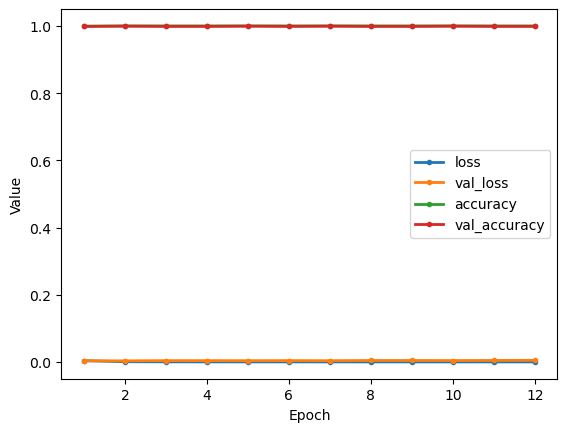

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/58 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step

 5/58 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

 9/58 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

14/58 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

19/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

23/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

27/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

31/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

35/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

40/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

45/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

49/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

53/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 1/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

 5/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

 9/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

13/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

17/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

21/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

25/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

29/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

33/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

37/58 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

41/58 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

46/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

50/58 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

55/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [26]:
report.save()

Report saved as Output/Reports/ARF/report_L61XXUW8.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################